<a href="https://colab.research.google.com/github/thecodeeagle/Genetic-Algorithm-Based-Ensemble-for-Driver-Distraction-Recognition/blob/main/Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My Drive

In [ ]:
!git clone https://github.com/thecodeeagle/yoga-82.git

In [ ]:
%cd yoga-82/

In [ ]:
%pycat models.py

In [ ]:
pip install Keras-Applications

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import keras
from keras.layers import Dense,Dropout,Conv2D,Input,MaxPool2D,Flatten,Activation, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, Conv2D, Concatenate
from keras.models import Model
keras.backend.set_image_data_format('channels_last')



from keras.applications.resnet import ResNet50, ResNet101
#from keras_applications.resnet_v2 import ResNet50V2, ResNet101V2
#from keras_applications.mobilenet import MobileNet
#from keras_applications.mobilenet_v2 import MobileNetV2
#from keras_applications.resnext import ResNeXt50, ResNeXt101
from keras_applications.densenet import DenseNet121, DenseNet169, DenseNet201



from keras_densenet_modified import DenseNet201_hir

def dense_block(x, blocks, name):
    """A dense block.

    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.

    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.

    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 #if backend.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def model_one_class(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    # for results of sota papers
    inputs = Input(input_shape)
    base_model= ResNet50(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= ResNet101(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= ResNet50V2(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= ResNet101V2(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= DenseNet121(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= DenseNet169(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= DenseNet201(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= MobileNet(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= MobileNetV2(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= ResNeXt50( input_tensor = inputs, include_top = False, weights = None,backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    #base_model= DenseNet121(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    

    x=  base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs=inputs, outputs= [x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model


def dense201_hirar(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    
    # for variant 1 in the paper

    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights='imagenet', input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
   
    [x1,x2,x] = base_model.output

    x1 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class6_last')(x1)
    x1 = Activation('relu', name='relu_class6_last')(x1)                                                                                                                                                                                                                                                                    
    x1 = GlobalAveragePooling2D(name='GAvgPool_class6_last')(x1)
    x2 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class20_last')(x2)
    x2 = Activation('relu', name='relu_class20_last')(x2)
    x2 = GlobalAveragePooling2D(name='GAvgPool_class20_last')(x2)
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(class_6, activation= 'softmax')(x1)
    x2 = Dense(class_20, activation= 'softmax')(x2)
    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs, [x1,x2,x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model

def dense201_hirar_6same20(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    
    # for variant 2 in the paper
    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)

    [null,x2,x] = base_model.output

    x1 = BatchNormalization(epsilon=1.001e-5, name = 'bn_class6_last')(x2)
    x1 = Activation('relu', name='relu_class6_last')(x1)
    x1 = GlobalAveragePooling2D(name='GAvgPool_class6_last')(x1)
    x2 = BatchNormalization(epsilon=1.001e-5, name = 'bn_class20_last')(x2)
    x2 = Activation('relu', name='relu_class20_last')(x2)
    x2 = GlobalAveragePooling2D(name='GAvgPool_class20_last')(x2)
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(class_6, activation= 'softmax')(x1)

    x2 = Dense(class_20, activation= 'softmax')(x2)

    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs, [x1,x2,x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model
def dense201_hirar_new(
        input_shape = (224,224,3),
        class_6=512,
        class_20=128,
        class_82=10):

    # for variant 3 in the paper

    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights='imagenet', input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
     
    x1 = dense_block(base_model.output[-1], 32, name='denseblockClass6')
    l = Flatten()(x1)
    x = Dense(10, activation='softmax')(l)

    model = Model(inputs, x)

    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [ ]:
p = dense201_hirar_new()

In [ ]:
p.summary()

In [ ]:
%cd ../../../

/content


In [ ]:
import numpy as np
loaded = np.load('drive/My Drive/newdriver.npz')

In [ ]:
train_images = loaded['train_images']
train_labels = loaded['train_labels']

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import keras
from tensorflow.keras import datasets,models,layers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras

In [ ]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
       
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "Training Loss")
            plt.plot(N, self.acc, label = "Training Accuracy")
            plt.title("Training Loss and Accuracy ")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [ ]:
p.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.0001),metrics=["acc"])

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)

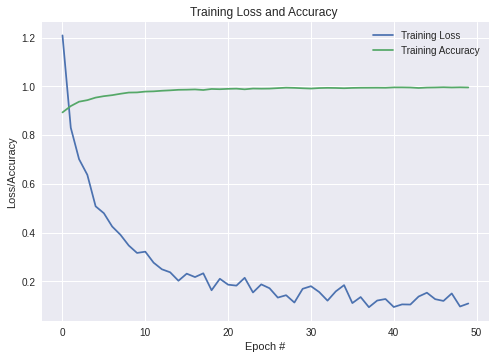

In [ ]:
history = p.fit(train_images, train_labels, epochs = 50, batch_size = 64, callbacks=[plot_losses])

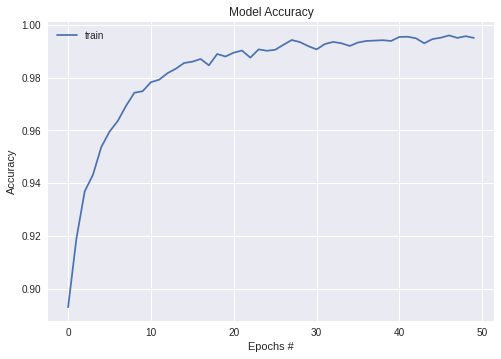

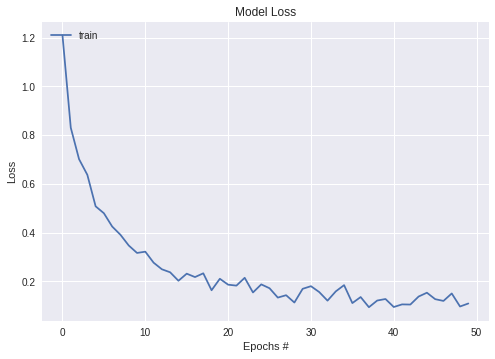

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs #')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs #')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
test_images = loaded['test_images']
test_labels = loaded['test_labels']

In [ ]:
test_labels = np.load('content/drive/My Drive/test_labels.npy')

In [ ]:
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

In [ ]:
p.evaluate(test_images,test_labels)

144/144 [==============================] - 33s 191ms/step - loss: 2.8615 - accuracy: 0.9363


[2.861501455307007, 0.9362766146659851]

In [ ]:
p.save("drive/My Drive/new_densenet3")

INFO:tensorflow:Assets written to: drive/My Drive/new_densenet3/assets
